# EDA FOR DEPLOYED SMART-CONRACTS ON A BLOCKCHAIN

The task involves performing an exploratory data analysis (EDA) on a dataset of smart contracts deployed on a blockchain. This dataset includes the contracts' bytecode, opcodes, and related information. The goal is to understand the dataset, identify patterns and inconsistencies, and propose potential data preprocessing and model training approaches.

A smart contract is a self-executing program that runs on the blockchain. While smart contracts can perform legitimate operations, they can also be used maliciously in fraudulent schemes, such as financial scams like Ponzi schemes and exploits.


The dataset contains labeled data of smart contracts deployed on various blockchain networks. It includes the following columns:
- address - Address of the contract
- chain_id - ID of the blockchain where the contract is deployed
- bytecode - Compiled code that runs on the blockchain
- opcode - Human-readable instructions derived from bytecode
- malicious_category_l1 - First level of the malicious category
- malicious_category_l2 - Second level of the malicious category
- data_source - Generalized data source of the sample
- man_validated - Boolean flag indicating if the contract label was manually reviewed
- man_validated_by - Reviewer who performed the validation
- comment - Comment provided by the reviewer
- label - Label of the smart contract

### Imports and configuration

In [1]:
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

Importing data from local directory:

In [2]:
data = pd.read_csv('test_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3923 entries, 0 to 3922
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   address                3923 non-null   object
 1   chain_id               3923 non-null   int64 
 2   bytecode               3923 non-null   object
 3   opcode                 3923 non-null   object
 4   malicious_category_l1  550 non-null    object
 5   malicious_category_l2  550 non-null    object
 6   data_source            3923 non-null   object
 7   man_validated          3791 non-null   object
 8   man_validated_by       944 non-null    object
 9   comment                1004 non-null   object
 10  label                  3923 non-null   object
dtypes: int64(1), object(10)
memory usage: 337.3+ KB


### Preprocessing

##### Duplicates

Check for duplicates in columns where there shouldn't be any.

The sequence of columns with the largest number of unique values was selected: 
- `address` 
- `bytecode`
- `opcode`

Let's check the number of duplicates in them.

In [3]:
def count_duplicates(df, columns):
    duplicate_counts = {}
    for column in columns:
        duplicate_counts[column] = df.duplicated(subset=[column], keep=False).sum()
    return duplicate_counts

unique_columns = ['address', 'bytecode', 'opcode']
duplicate_counts = count_duplicates(data, unique_columns)
duplicate_counts

{'address': 32, 'bytecode': 42, 'opcode': 18}

We can see that there are duplicates in each of these sections. I suggest checking the columns starting with the ones with the most duplicates in order to avoid unnecessary work.

The first column in the analysis will be `bytecode`.

The `bytecode` does not have to be unique, so it should be checked only in combination with other parameters.

As a rule, if we have a duplicate `address`, `blockchain` on which the smart contract was deployed, and `bytecode`, the problem is elsewhere.

In [4]:
duplicates = data[data.duplicated(subset=['address', 'chain_id', 'bytecode'], keep=False)]
duplicates = duplicates[['address', 'chain_id', 'bytecode', 'opcode', 'label']].sort_values(by=['address'])
duplicates

,address,chain_id,bytecode,opcode,label
180,0x1896adbe708bf91158748b3f33738ba497a69e8f,1,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Clean
1731,0x1896adbe708bf91158748b3f33738ba497a69e8f,1,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Clean
1833,0x634322671380cf1ee7bd555a77fcdd41e680d817,1,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Clean
2505,0x634322671380cf1ee7bd555a77fcdd41e680d817,1,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Clean
1066,0x831091da075665168e01898c6dac004a867f1e1b,1,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Clean
2945,0x831091da075665168e01898c6dac004a867f1e1b,1,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Clean
602,0xa489fdc65229d6225014c0b357bcd19af6f00ee9,42161,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Clean
1810,0xa489fdc65229d6225014c0b357bcd19af6f00ee9,42161,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Clean
79,0xc0a47dfe034b400b47bdad5fecda2621de6c4d95,1,0x600035601c5274010000000000000000000000000000...,PUSH1 CALLDATALOAD PUSH1 MSTORE PUSH21 0100000...,Clean
209,0xc0a47dfe034b400b47bdad5fecda2621de6c4d95,1,0x600035601c5274010000000000000000000000000000...,PUSH1 CALLDATALOAD PUSH1 MSTORE PUSH21 0100000...,Clean


As we can see, 2 additional columns were added to the analysis, one of which (`opcode`) determines the difference between duplicates, and the `label` column is needed to check whether duplicates are of different classes.

Since the initial part of the `opcode` is the same, we had the idea to start analyzing these str-expressions from the end, so below is the code for finding differences by `opcode` among pairwise duplicates:

In [5]:
indexes_to_drop = []
ids = []

for i in range(0, len(duplicates), 2):
    opcode1 = duplicates.iloc[i]['opcode'].split()
    opcode1.reverse()
    opcode2 = duplicates.iloc[i + 1]['opcode'].split()
    opcode2.reverse()
    
    for j in range(len(opcode1)):
        if opcode1[j] != opcode2[j]:
            print(f"Opcode mismatch: {opcode1[j:j+5]} != {opcode2[j:j+5]}")
            for n in opcode1[j:j+5]:
                if not n.isupper():
                    indexes_to_drop.append(i)
                    break
            for n in opcode2[j:j+5]:
                if not n.isupper():
                    indexes_to_drop.append(i + 1)
                    break
            break
            
for index in indexes_to_drop:
    ids.append(duplicates.iloc[index])

ids = pd.DataFrame(ids)

data.drop(ids.index, inplace=True)


Opcode mismatch: ['JUMP', 'POP', 'SWAP1', 'SWAP2', 'SWAP1'] != ['Opcode)', "'bd'(Unknown", 'Opcode)', "'22'(Unknown", 'STOP']
Opcode mismatch: ['STOP', 'STOP', 'STOP', 'Opcode)', "'c7'(Unknown"] != ['REVERT', 'DUP1', 'PUSH1', 'JUMPI', 'PUSH2']
Opcode mismatch: ['JUMP', 'PUSH2', 'ADD', 'PUSH1', 'SSTORE'] != ['Opcode)', "'bd'(Unknown", 'Opcode)', "fe'(Unknown", 'Opcode)']
Opcode mismatch: ['STOP', 'STOP', 'STOP', 'Opcode)', "fe'(Unknown"] != ['JUMP', 'POP', 'POP', 'SWAP2', 'SWAP3']
Opcode mismatch: ['Opcode)', "'c7'(Unknown", 'Opcode)', "fe'(Unknown", 'Opcode)'] != ['REVERT', 'PUSH1', 'PUSH1', 'JUMPDEST', 'STOP']


As a result, we get the following situation: one of the pair of duplicates has artifacts that do not look like the general style of the presented opcode. That is, bracketed characters, lower-cases, and Unknown values.

Therefore, in order to get rid of duplicates, I decided to remove the line indices that had potential artifacts.

Theoretically, this was a problem in the bytecode decryption itself and because of the difference between existing instances, these duplicates were added to the dataset.

In [6]:
duplicates = data[data.duplicated(subset=['address', 'chain_id', 'bytecode'], keep=False)]
duplicates = duplicates[['address', 'chain_id', 'bytecode', 'opcode', 'label']].sort_values(by=['address'])
duplicates

,address,chain_id,bytecode,opcode,label


Let's move on to the next column that has duplicates: `address`.

The general rule for the uniqueness of smart contract `addresses` is that they must be unique within the same `blockchain`.

Therefore, let's check the unique `blockchain id` and `labels` to prevent the situation when instances with the same address have different classes.

In [7]:
duplicate_addresses = data[data.duplicated(subset=['address'], keep=False)]

output = []

for address, group in duplicate_addresses.groupby('address'):
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            row1 = group.iloc[i]
            row2 = group.iloc[j]
            output.append({
                'I': (row1['chain_id'], row1['label']),
                'II': (row2['chain_id'], row2['label']),
                'Address': address
            })

output_df = pd.DataFrame(output)
output_df

,I,II,Address
0,"(43114, Clean)","(42161, Clean)",0x23208b91a98c7c1cd9fe63085bff68311494f193
1,"(1, Clean)","(42161, Clean)",0x26cfb7ef8fce43c8819b33c02f3d0498072e6fe1
2,"(137, Clean)","(1, Clean)",0x2e96068b3d5b5bae3d7515da4a1d2e52d08a2647
3,"(43114, Clean)","(42161, Clean)",0x64b57f4249aa99a812212cee7daefedc40b203cd
4,"(43114, Exploit)","(1, Exploit)",0x8c425ee62d18b65cc975767c27c42de548d133a1
5,"(56, Clean)","(137, Clean)",0x8ef71fde0681f567d241a2cb7f2ae46d6d709d30
6,"(56, Clean)","(1, Clean)",0x9bbdef63594d5ffc2f370fe52115ddffe97bc524
7,"(43114, Exploit)","(56, Exploit)",0x9be508ce41ae5795e1ebc247101c40da7d5742db
8,"(43114, Clean)","(56, Clean)",0xb4315e873dbcf96ffd0acd8ea43f689d8c20fb30
9,"(137, Exploit)","(1, Exploit)",0xdfcdb5a86b167b3a418f3909d6f7a2f2873f2969


As you can see from the table above, all duplicates in the `address` column have different `blockchains` and identical `labels`, which is why these duplicates do not require any manipulation.

Let's move on to the last column with potential duplicates.

Duplicate `opcodes` can exist only if one `opcode` instance corresponds to only one `bytecode` instance. Accordingly, let's check all duplicates for `bytecode` similarity and, at the same time, make sure that the same code was not deployed on the same `blockchain`.


In [8]:
duplicate_opcodes = data[data.duplicated('opcode', keep=False)].sort_values(by='opcode')

pairs_info = []
indices_to_remove = []

for opcode, group in duplicate_opcodes.groupby('opcode'):
    # Assume exactly 2 rows in 'group'
    if len(group) == 2:
        row1 = group.iloc[0]
        row2 = group.iloc[1]
        same_bc = (row1['bytecode'] == row2['bytecode'])
        
        pairs_info.append({
            'same_bytecode': same_bc,
            'label_1': row1['label'],
            'label_2': row2['label'],
            'chain_id_1': row1['chain_id'],
            'chain_id_2': row2['chain_id'],
            'opcode': opcode
        })
        
        if not same_bc:
            indices_to_remove.extend(group.index)
    else:
        print(f"Unexpected group size: {len(group)}")

output_df = pd.DataFrame(pairs_info)
output_df


,same_bytecode,label_1,label_2,chain_id_1,chain_id_2,opcode
0,True,Clean,Clean,10,56,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH1...
1,True,Clean,Clean,10,42161,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
2,True,Clean,Clean,56,10,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
3,True,Clean,Clean,10,42161,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
4,False,Clean,Clean,10,42161,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
5,True,Clean,Clean,10,42161,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
6,False,Clean,Clean,10,42161,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
7,False,Clean,Clean,10,42161,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
8,True,Clean,Clean,137,10,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...


As we can see, there are 3 pairs in the duplicate set that do not match the `bytecode`, so to eliminate possible inaccuracies, these pairs will be removed from the final data set.

In [9]:
data.drop(indices_to_remove, inplace=True)

Here are the results of the removal:

In [10]:
duplicate_opcodes = data[data.duplicated(subset=['opcode'], keep=False)]

output = []

for opcode, group in duplicate_opcodes.groupby('opcode'):
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            row1 = group.iloc[i]
            row2 = group.iloc[j]
            same_bytecode = row1['bytecode'] == row2['bytecode']
            output.append({
                'same_bytecode': same_bytecode,
                'label_1': row1['label'],
                'label_2': row2['label'],
                'chain_id_1': row1['chain_id'],
                'chain_id_2': row2['chain_id'],
                'opcode': opcode
            })

output_df = pd.DataFrame(output)
output_df

,same_bytecode,label_1,label_2,chain_id_1,chain_id_2,opcode
0,True,Clean,Clean,10,56,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH1...
1,True,Clean,Clean,42161,10,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
2,True,Clean,Clean,10,56,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
3,True,Clean,Clean,42161,10,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
4,True,Clean,Clean,10,42161,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
5,True,Clean,Clean,137,10,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...


##### Empty values

With the duplicates done, let's move on to processing the columns that have empty values.

The first of them will be `malicious_category_l1` and `malicious_category_l2`.

We display the total ratio by class and the number of instances in the above columns:

In [11]:
print(f"Value counts in {data['label'].value_counts()}", end='\n\n')
print(f"Value counts in {data['malicious_category_l1'].value_counts()}", end='\n\n')
print(f"Value counts in {data['malicious_category_l2'].value_counts()}")

Value counts in label
Clean            3363
Exploit           349
FinancialScam     200
Name: count, dtype: int64

Value counts in malicious_category_l1
Cyber    349
Fraud    201
Name: count, dtype: int64

Value counts in malicious_category_l2
Exploit          349
FinancialScam    201
Name: count, dtype: int64


We can see that the columns match our `label`, but there is a difference of one instance. 

Let's try to find this difference.

In [12]:
data_copy = data.copy()
data_copy = data_copy.dropna(subset=['malicious_category_l2'])
mismatch_rows = data_copy[data_copy['malicious_category_l2'] != data_copy['label']]
mismatch_rows

,address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
2242,0x71f57929a3c4387dc9573413059a9dc8b106bdce,56,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Fraud,FinancialScam,Public_Historical_Data,NaN,NaN,"reported by HashDit, ponzi",Clean


We can see that the only instance that doesn't match the `label` has a comment that says it was a pyramid (ponzi) scheme report. 

Therefore, I can conclude that the `label` with the value Clean is false. In order not to lose a single instance of data of a negative class, we assign the FinancialScam class to this instance.

In [13]:
data.loc[mismatch_rows.index, 'label'] = data.loc[mismatch_rows.index, 'malicious_category_l2']

temp_data = data.copy().dropna(subset=['malicious_category_l2'])
mismatch_rows_updated = temp_data[temp_data['malicious_category_l2'] != temp_data['label']]

print(f"Number of mismatched rows: {len(mismatch_rows_updated)}")

Number of mismatched rows: 0


Now the situation is as follows: the `malicious_category_l1` and `malicious_category_l2` columns completely duplicate the information in our label, so there is no point in using them in the future.

In [14]:
data.drop(['malicious_category_l1', 'malicious_category_l2'], axis=1, inplace=True)

Let's move on to the next column `man_validated`.

It should store boolean values of whether the instance was manually validated.

In order to fill in the empty values, you need to make sure that there is no situation where there is a validating person, but there is no mark that the person has validated.

In [15]:
filtered_data = data[data['man_validated'].isnull() & data['man_validated_by'].notnull()]
print(f"Number of rows with None in man_validated and not None in man_validated_by: {len(filtered_data)}")

Number of rows with None in man_validated and not None in man_validated_by: 0


Since there are no such situations, it would be logical to say that this instance was not manually checked, respectively, empty values can be filled with False.

In [16]:
data['man_validated'] = data['man_validated'].fillna(False)

Let's move on to the next column, `man_validated_by`.
This is the column that shows who was the reviewer of a particular instance. Let's see what values are available.

In [17]:
print(f"Value counts in {data['man_validated_by'].value_counts()}", end='\n\n')
print(f"Count of null values in man_validated_by: {data['man_validated_by'].isnull().sum()}")

Value counts in man_validated_by
Reviewer2    525
Reviewer1    248
Reviewer3    164
Reviewer4      1
Name: count, dtype: int64

Count of null values in man_validated_by: 2974


We can see that we have one unique case and a huge number of missing values.

First, let's consider the unique case and whether it should be excluded from the dataset.

In [18]:
data[data['man_validated_by'] == 'Reviewer4']

,address,chain_id,bytecode,opcode,data_source,man_validated,man_validated_by,comment,label
2908,0x3816A80F324B8f6F34cF76E5Ba9A256130d37f50,42161,0x608060405234801561001057600080fd5b5060043610...,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...,Public_Historical_Data,True,Reviewer4,"Deployer: N/A, re-entrency attack contract.",Exploit


Since this is an instance of a negative class, it cannot be lost (there are several times fewer negative classes than positive ones, each instance has a weight).

We'll fill in the empty values with a stub, since we can't get any information about who checked a particular instance.


In [19]:
data['man_validated_by'] = data['man_validated_by'].fillna("NoReviewer")

##### NLP

And finally, the most interesting and informative column of the entire dataset is `comment`.
It's easy to see that it contains patterns that can help determine the final class.

The first thing to look for is suspicious words that directly indicate that the copy is somehow an `exploit` or `financial scam`.

I've identified the following words that can help categorize an instance: `fraud`, `scam`, `phishing`, `ponzi`, `exploit`, `hack`, `steal`, `fake`, `suspicious`, `malicious`.

To find these words and modified forms, I will use `lemmatization`.
Also, we should not forget that there are negative constructions with these words, which, on the contrary, say that the instance is clean.
Below is the implementation of the algorithm that creates a column with suspicious words removed from the comments.


In [ ]:
# spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

suspect_keywords = [
    "fraud", "scam", "phish", "phishing", "ponzi", 
    "exploit", "hack", "launder", "steal", "fake", "suspicious", "malicious"
]

def is_partial_match(token_lemma: str, keywords: list) -> bool:
    """
    Check if the lemma occurs partially in one of the keywords
    OR the keyword occurs partially in a lemma.
    """
    for kw in keywords:
        if kw in token_lemma or token_lemma in kw:
            return True
    return False

def is_negated(token) -> bool:
    """
    Check if the token or its ancestors have a negative dependency (dep_ == 'neg').
    If yes, we consider that this token is negated (e.g., “not malicious”).
    """
    
    for child in token.children:
        if child.dep_ == 'neg':
            return True
    
    for ancestor in token.ancestors:
        for child in ancestor.children:
            if child.dep_ == 'neg':
                return True
    
    return False

def extract_suspect_words_spacy(comment, keywords, nlp_model):
    
    if not isinstance(comment, str):
        return []
    
    doc = nlp_model(comment.lower())

    found = []
    for token in doc:
        if token.is_alpha and not token.is_stop and len(token.lemma_) >= 3:
            if is_partial_match(token.lemma_, keywords):
                if not is_negated(token):
                    found.append(token.text)
    
    return found

data["suspect_terms"] = data["comment"].apply(
    lambda c: extract_suspect_words_spacy(c, suspect_keywords, nlp)
)

data[data['comment'].notna()][['comment', 'suspect_terms']].head(10)

,comment,suspect_terms
3,Data additionally gathered from Rekt db,[]
17,Trade bot,[]
21,Tries to mint something then transfer,[]
23,Balancer Exploiter,[exploiter]
24,"Rugpull, owner used ""backdoor"" function to inf...",[]
26,Doesnt look malicious,[]
30,Trade bot,[]
31,Hedgey Finance's exploit,[exploit]
32,Looks scammy,[scammy]
33,GMXRebalance,[]


Let's check which words were selected by the algorithm and how many instances were marked.

In [21]:
print(f"Number of rows with suspect terms: {data['suspect_terms'].apply(len).sum()}", end='\n\n')
print(f"Value counts in {data['suspect_terms'].value_counts()}")

Number of rows with suspect terms: 276

Value counts in suspect_terms
[]                       3643
[exploit]                 107
[ponzi]                    34
[defihacklabs]             23
[fake]                     20
[scam]                     17
[malicious]                15
[phishing]                 11
[exploiter]                 9
[suspicious]                8
[scammy]                    6
[hack]                      4
[mal]                       3
[exploit, exploit]          2
[sus]                       2
[hacker]                    1
[exploit, malicious]        1
[suspicious, exploit]       1
[fake, scammer]             1
[scammers]                  1
[exploit, exploiter]        1
[ponzinomics]               1
[scammy, phishing]          1
Name: count, dtype: int64


Saving an intermediate state for empirical evaluation.

In [22]:
temp = data[data['comment'].notna()][['comment', 'suspect_terms', 'label']]
temp.to_csv('comment-suspect_terms-label.csv', index=False)

Now, let's check if there are any instances where the highlighted suspicious words are in the positive (clean) class:

In [23]:
data[data['suspect_terms'].apply(lambda x: len(x) > 0) & data['label'] == 'Clean'][['comment', 'suspect_terms', 'label']]

,comment,suspect_terms,label


As you can see, none of the clean instances were affected, so the algorithm can be considered successful.

Let's remove the comment column, since we have already extracted the information we need from there.

In [24]:
data.drop('comment', axis=1, inplace=True)

The final state of the dataset:

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3912 entries, 0 to 3922
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   address           3912 non-null   object
 1   chain_id          3912 non-null   int64 
 2   bytecode          3912 non-null   object
 3   opcode            3912 non-null   object
 4   data_source       3912 non-null   object
 5   man_validated     3912 non-null   object
 6   man_validated_by  3912 non-null   object
 7   label             3912 non-null   object
 8   suspect_terms     3912 non-null   object
dtypes: int64(1), object(8)
memory usage: 434.7+ KB


### EDA

Let's move on to the general analysis, for those columns that we have not yet analyzed.

We will also determine how the categorical columns affect the result of the final `label`.

The first step is to print the distribution in the `label`.

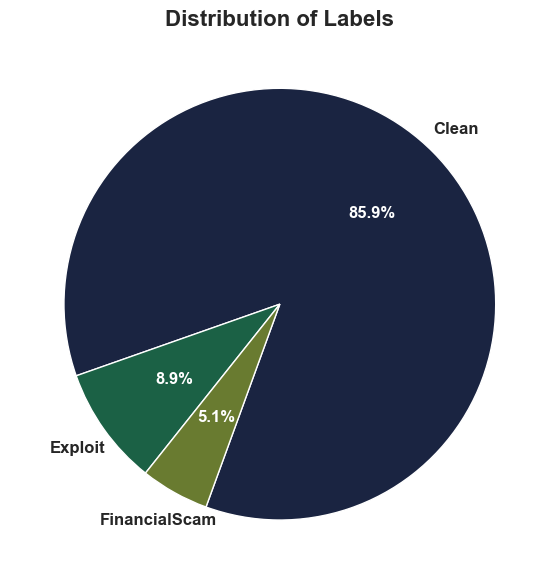

In [26]:
label_counts = data['label'].value_counts()

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 6))

wedges, texts, autotexts = ax.pie(
    label_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=250,
    colors=sns.color_palette("cubehelix"),
    textprops={'fontsize': 12, 'weight': 'bold', "color": "white"}
)

for i, wedge in enumerate(wedges):
    angle = (wedge.theta1 + wedge.theta2) / 2
    x = 1.15 * np.cos(np.radians(angle))
    y = 1.15 * np.sin(np.radians(angle))
    ax.text(x, y, label_counts.index[i], ha='center', va='center', fontsize=12, weight='bold')

ax.set_title("Distribution of Labels", fontsize=16, weight='bold')

plt.tight_layout()
plt.show()


The distribution is neither too good nor too bad - ~15% belong to the negative class in the binary classification. 

If we talk about multi-class, the situation is more complicated and, theoretically, the model will be harder to train.

Let's try to plot the distribution of categorical data in relation to our `label`. Below is the code for creating a general graph.

In [27]:
sns.set_theme(style="darkgrid")

def plot_combined_histogram(data, column_name, title_name, color_lst):
    chain_counts = data[column_name].value_counts()
    all_ids = chain_counts.index

    def plot_histogram(sub_data, label, ax, color, offset, total_labels=3):
        subset = sub_data[sub_data['label'] == label]
        count_series = subset[column_name].value_counts()
        y_values = [count_series.get(cid, 0) for cid in all_ids]
        x = np.arange(len(all_ids))
        width = 0.8 / total_labels
        bars = ax.bar(x + offset * width, y_values, width=width, color=color, label=label)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 2), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    fig, ax = plt.subplots(figsize=(10, 5))
    

    plot_histogram(data, 'Clean', ax, color_lst[0], 0, total_labels=3)
    plot_histogram(data, 'Exploit', ax, color_lst[1], 1, total_labels=3)
    plot_histogram(data, 'FinancialScam', ax, color_lst[2], 2, total_labels=3)

    x = np.arange(len(all_ids))
    width = 0.8 / 3
    ax.set_xticks(x + width)
    ax.set_xticklabels(all_ids)
    ax.set_xlabel(column_name)
    ax.set_title(title_name)
    ax.legend()
    plt.tight_layout()
    plt.show()

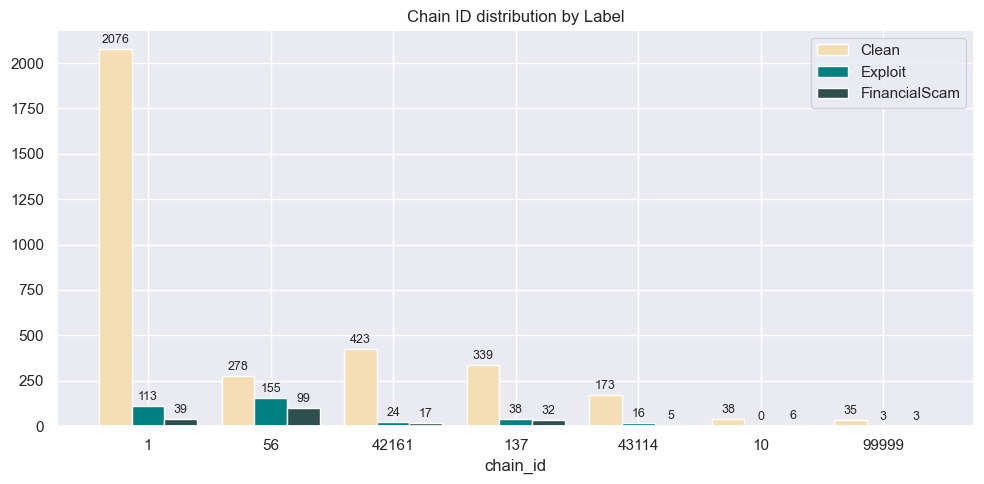

In [28]:
plot_combined_histogram(data, 'chain_id', 'Chain ID distribution by Label', ['wheat', 'teal', 'darkslategray'])

What conclusions can be drawn:
- The most secure blockchain is the one with a unique number 1 (percentage-wise, it has the lowest number of `exploits` and `scam`).
- The most vulnerable was 56, as the number of net contracts almost corresponds to the sum of `exploits` and `financial scam`.
- For the 43114, 10, and 99999 chains, there is too little information to draw any specific conclusions. 

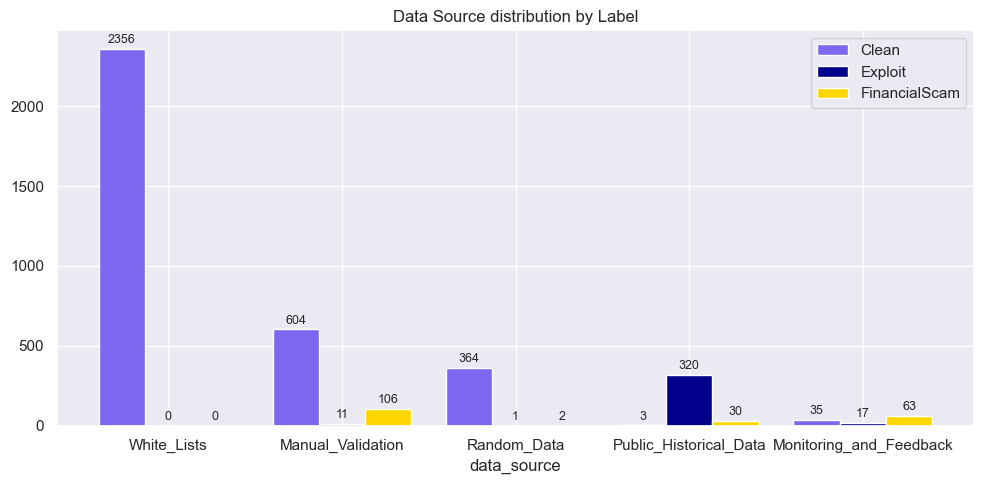

In [29]:
plot_combined_histogram(data, 'data_source', 'Data Source distribution by Label', ['mediumslateblue', 'darkblue', 'gold'])

White_Lists, respectively, is the preservation of guaranteed clean contracts, so all values there are positive.

If we talk about the category dominated by negative classes - Public_Historical_Data - it is obvious that these are selected vivid examples of fraudulent smart contracts. 
It is on the basis of this historical data that we will be able to train the model to recognize fraudulent contracts in the future.

### Conclusions

- In this paper, we analyzed the smart contract data, where the vast majority (~85%) are clean contracts.
- The dataset was checked for possible empty or duplicate data so that no conflicts would arise in the future when training potential models.
- Due to my lack of expertise, the bytecode and opcode columns were processed only at a surface level. With the right knowledge, I'm sure they can provide even more information. 
- In the absence of bytecode and opcode processing, the main marker for identifying fraudulent smart contracts was the comment column, from which the necessary data was extracted using lemmatization to create a separate category containing marker words.

Thank you for your time. The work was done by `Vladyslav Volokitin`.